# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [27]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split

In [29]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

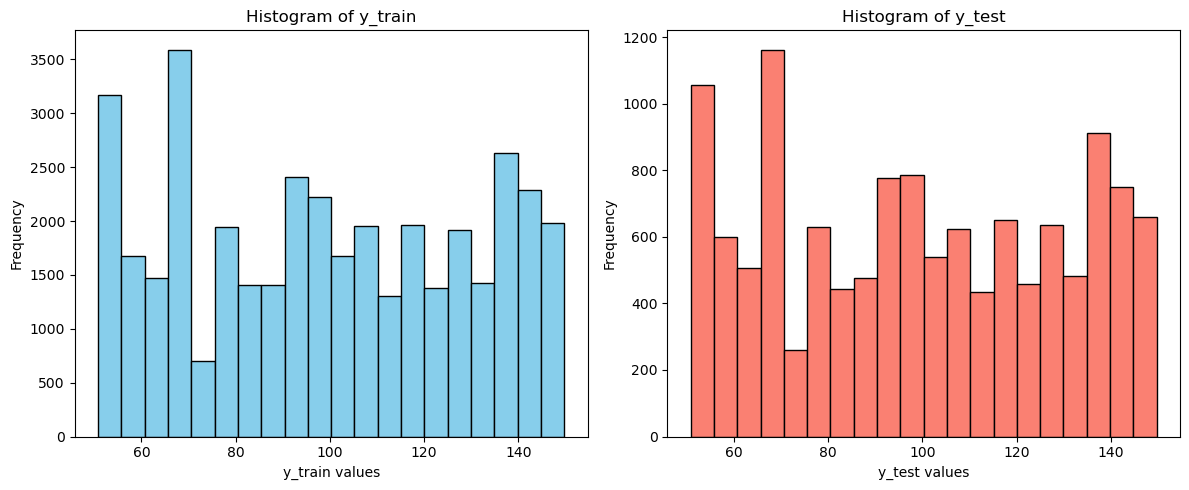

In [31]:
import matplotlib.pyplot as plt

# Plot histogram for y_train
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of y_train')
plt.xlabel('y_train values')
plt.ylabel('Frequency')

# Plot histogram for y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=20, color='salmon', edgecolor='black')
plt.title('Histogram of y_test')
plt.xlabel('y_test values')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


**Svar:**

Dette er snakk om en regresjon, da verdiene er kontinuerlige. Hvis man ser på barene så ligger de side-om-side og det er ingen tydelig diskret verdi de har.  

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [35]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
    import seaborn as sns



 # Beregn korrelasjonsmatrisen
    corr_matrix = X_temp.corr()
    
    # Visualiser korrelasjonsmatrisen
    plt.figure(figsize=(20, 18))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
    plt.title("Korrelasjonsmatrise mellom egenskaper og Target")
    plt.show()

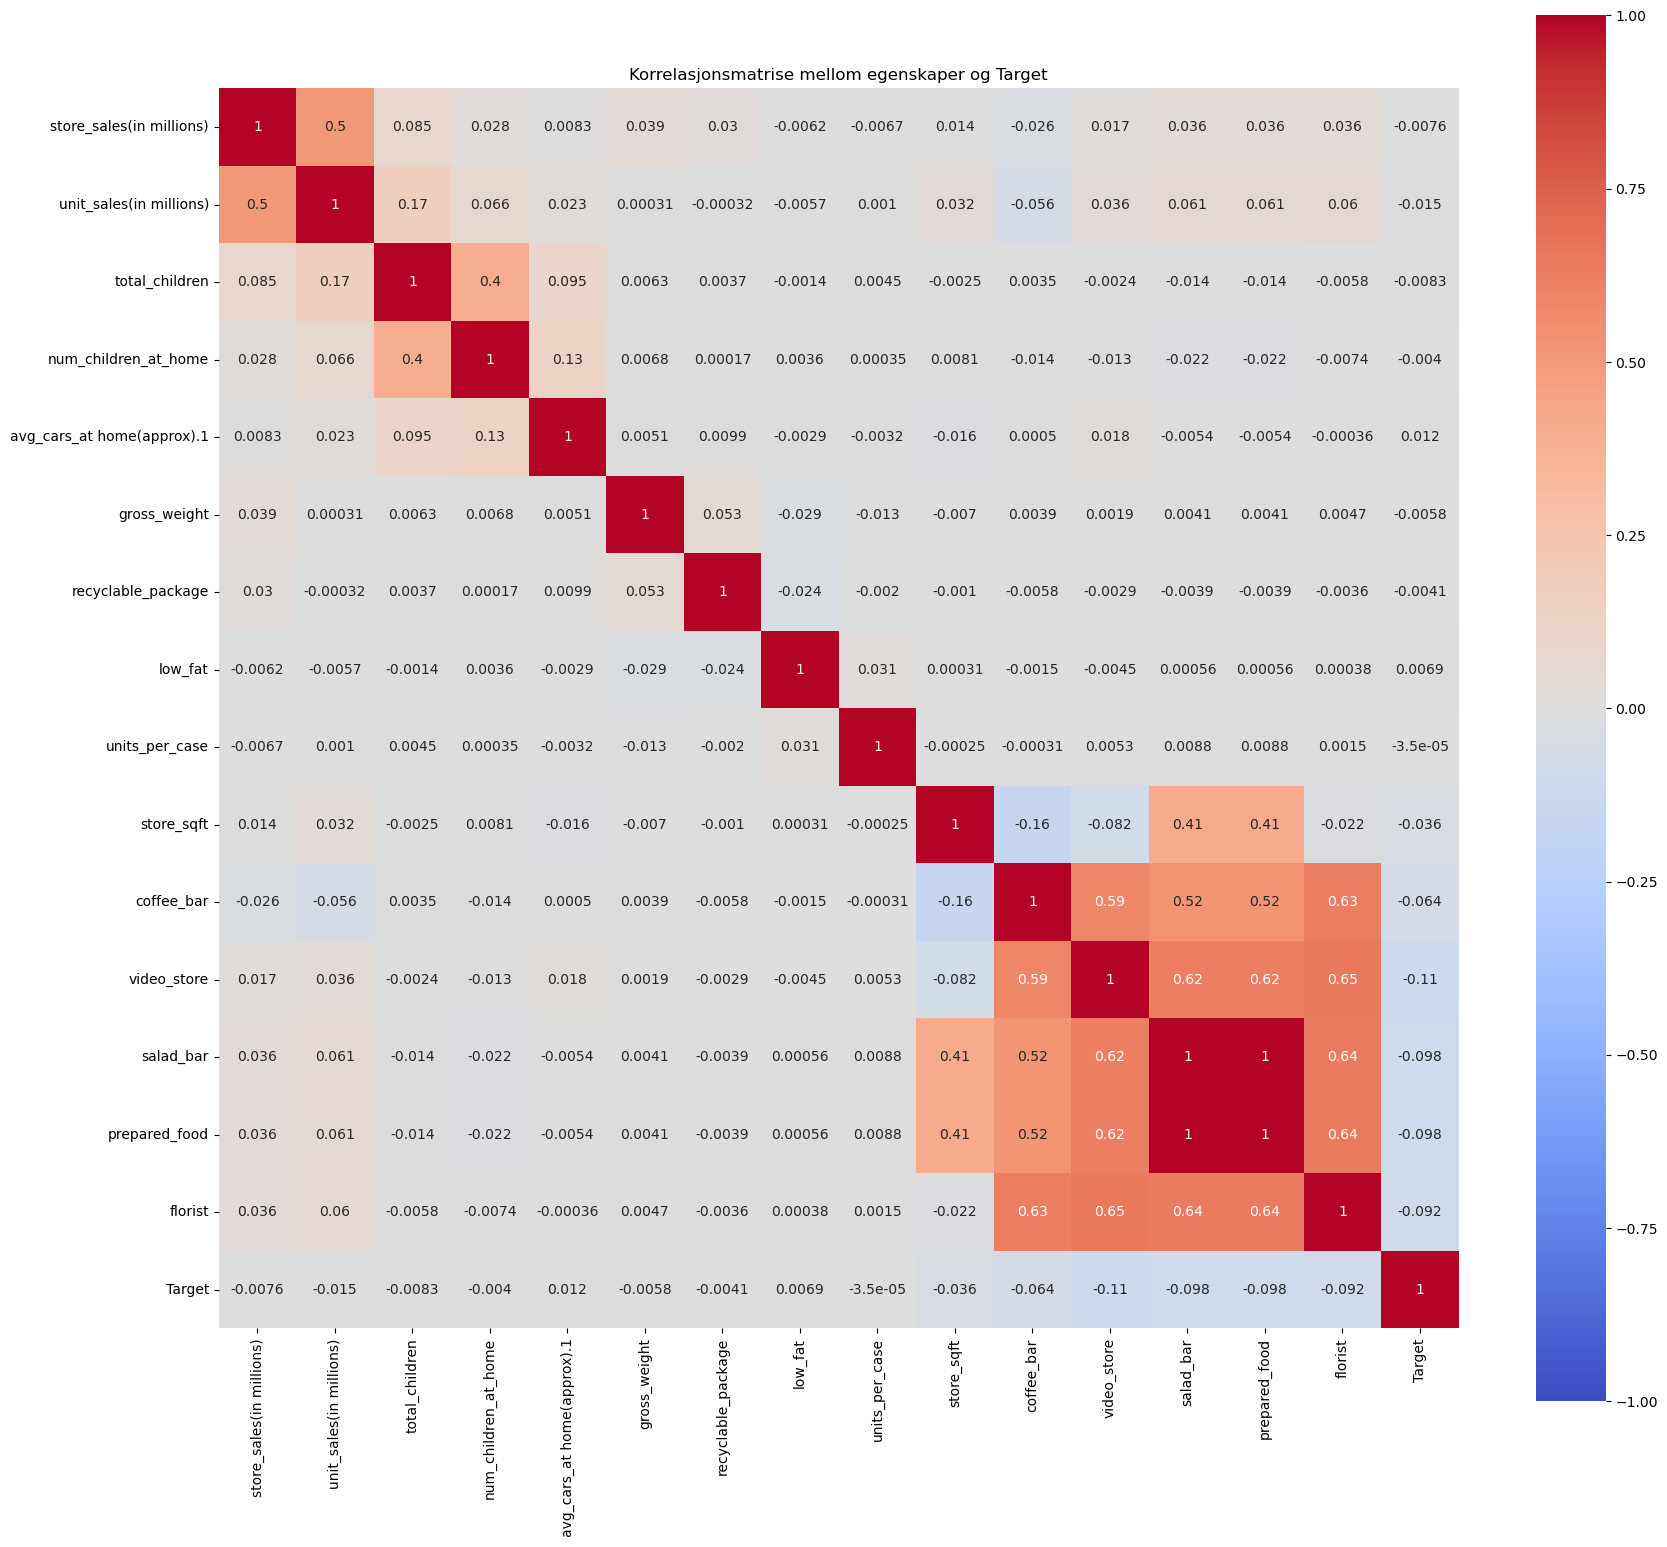

In [17]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

For å visualisere hvordan egenskaper korrelerer med målvariabelen, kan man kombinere egenskapene og målvariabelen i én matrise og beregne korrelasjonsmatrisen. Dette gir en oversikt over styrken og retningen på sammenhengen mellom variablene. Resultatet kan presenteres som et heatmap, der sterke positive korrelasjoner vises i varme farger og sterke negative korrelasjoner i kalde farger. Slik kan man raskt identifisere hvilke egenskaper som har sterkest sammenheng med målvariabelen, noe som er nyttig for videre analyse.



#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Splitt datasettet i egenskaper (X) og target (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Del inn i trening- og testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Velg modell
model = RandomForestRegressor(random_state=0)

# Definer hyperparametergrid
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, None],
    "min_samples_split": [2, 5]
}

# Konfigurer og kjør GridSearchCV
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3,  # Endret til 3-fold kryssvalidering
    verbose=2
)

# Utfør treningen
grid_search.fit(X_train, y_train)

# Beste hyperparametere og tilhørende skår
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Konverter til positiv verdi for forståelighet
print(f"Beste hyperparametere: {best_params}")
print(f"Beste MSE (gjennom kryssvalidering): {best_score}")

# Evaluer den beste modellen på testsettet
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error på testsettet: {mse}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END max_depth=10, min_samples_split=5, n_est

**Svar:**

Oppgaven begynte med å gjøre et hyperparametersøk med 3 parametere og 2 verdier per parameter. Dette ble gjort med # Definer hyperparametergrid
param_grid = {"n_estimators": [50, 100], "max_depth": [10, None], "min_samples_split": [2, 5]}
Deretter ble en tre-folds kryssvalidering gjort. Så ble neg_mean_squared_error brukt. Til slutt fikk vi printet at beste kombinasjonen var: Beste hyperparametere: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} med en score: Beste MSE (gjennom kryssvalidering): 851.2053181614632.


#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Velg de beste hyperparameterne fra oppgave 1.3
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
best_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"], 
    min_samples_split=best_params["min_samples_split"], 
    random_state=0
)

# K-fold kryssvalidering med K=5
kf = KFold(n_splits=5, shuffle=True, random_state=0)

mae_scores = []
mse_scores = []

# Kryssvalidering
for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Tren modellen på treningsfolden
    best_model.fit(X_train_fold, y_train_fold)
    
    # Prediksjoner på valideringsfolden
    y_val_pred = best_model.predict(X_val_fold)
    
    # Beregn metrikker
    mae_scores.append(mean_absolute_error(y_val_fold, y_val_pred))
    mse_scores.append(mean_squared_error(y_val_fold, y_val_pred))

# Beregn gjennomsnitt og standardavvik
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)

# Gjennomsnittlig faktisk pris i treningsdataene
mean_actual_price = np.mean(y_train)

# Relativ feil
relative_mae = (mae_mean / mean_actual_price) * 100

# Logg resultatene
print("Resultater fra kryssvalidering:")
for i, (mae, mse) in enumerate(zip(mae_scores, mse_scores), 1):
    print(f"Fold {i}: MAE={mae:.2f}, MSE={mse:.2f}")

print(f"\nGjennomsnitt MAE: {mae_mean:.2f} (std: {mae_std:.2f})")
print(f"Gjennomsnitt MSE: {mse_mean:.2f} (std: {mse_std:.2f})")
print(f"Gjennomsnittlig faktisk pris: {mean_actual_price:.2f}")
print(f"Relativ MAE: {relative_mae:.2f}%")


Resultater fra kryssvalidering:
Fold 1: MAE=25.12, MSE=848.55
Fold 2: MAE=25.07, MSE=845.99
Fold 3: MAE=24.97, MSE=848.55
Fold 4: MAE=25.12, MSE=853.43
Fold 5: MAE=25.14, MSE=853.10

Gjennomsnitt MAE: 25.09 (std: 0.06)
Gjennomsnitt MSE: 849.92 (std: 2.89)
Gjennomsnittlig faktisk pris: 99.34
Relativ MAE: 25.25%


**Svar:**
Resultatene fra kryssvalideringen med K = 5 viser at modellen, trent med den beste hyperparameterkombinasjonen fra oppgave 1.3, gir et gjennomsnittlig MAE (Mean Absolute Error) på 25.09, med et standardavvik på 0.06, og et gjennomsnittlig MSE (Mean Squared Error) på 849.92, med et standardavvik på 2.89. Dette indikerer at modellen har en relativt stabil ytelse på tvers av de fem foldene. Den gjennomsnittlige faktiske prisen i treningsdataene er 99.34, og den gjennomsnittlige feilen på 25.09 representerer en relativ MAE på 25.25%, som betyr at modellen i gjennomsnitt gjør en feil på omtrent en fjerdedel av den faktiske prisen. Dette kan betraktes som en akseptabel feilrate for regresjon, selv om det fortsatt er potensial for forbedring av modellen for å redusere feilen ytterligere.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Bruk de optimale hyperparameterne fra Oppgave 1.3
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
final_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"], 
    min_samples_split=best_params["min_samples_split"], 
    random_state=0
)

# Tren modellen på hele treningssettet
final_model.fit(X_train, y_train)

# Gjør prediksjon på testsettet
y_test_pred = final_model.predict(X_test)

# Beregn MAE og MSE for testsettet
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Gjennomsnittlig faktisk pris i testsettet
mean_actual_price_test = np.mean(y_test)

# Relativ MAE
relative_mae_test = (test_mae / mean_actual_price_test) * 100

# Print resultatene
print("Resultater for testsettet:")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {test_mse:.2f}")
print(f"Gjennomsnittlig faktisk pris i testsettet: {mean_actual_price_test:.2f}")
print(f"Relativ MAE: {relative_mae_test:.2f}%")


Resultater for testsettet:
Mean Absolute Error (MAE): 25.11
Mean Squared Error (MSE): 847.96
Gjennomsnittlig faktisk pris i testsettet: 99.30
Relativ MAE: 25.29%


**Svar:**

Resultatene fra modellen viser at den gjennomsnittlige absolutte feilen (MAE) på testsettet er 25.11. Dette betyr at modellens prediksjoner, i gjennomsnitt, avviker med 25.11 enheter fra de faktiske verdiene i testsettet. Når vi ser på den gjennomsnittlige faktiske prisen i testsettet, som er 99.30, får vi en relativ MAE på 25.29%. Dette innebærer at den gjennomsnittlige feilen i modellens prediksjoner er 25.29% av den faktiske gjennomsnittlige prisen. En relativ MAE på 25% kan være akseptabelt avhengig av domene og dataenes karakter. Hvis prisene i datasettet er høye, kan 25% representere en betydelig feil, mens den kan være mer tolerabel hvis prisene er lavere. Generelt sett er det viktig å vurdere hva en feil på 25% betyr i konteksten av det spesifikke problemet som modellen prøver å løse.






